**Installing modules and Importing Libraries**

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

**Loading the models and dataset**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
clip_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f'Total number of images in CIFAR 10 test_loader: {len(test_dataset)}')

cifar10_classes = [
    'airplane', 'automobile',  'ship', 'truck'
    'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
]

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Total number of images in CIFAR 10 test_loader: 10000


# Util functions

In [7]:
def load_image(image_input):
    if not isinstance(image_input, torch.Tensor):
        image = Image.open(image_input)
        image = image.resize((224, 224), Image.LANCZOS)
        image_array = np.array(image)
    else:  #tensors from dataset are already resized
      image = image_input
      if image_input.dim() == 4:  #extra batch dimension
        image_array = image_input.squeeze(0).cpu().numpy()
      else:
        image_array = image_input.cpu().numpy()


    if isinstance(image_input, torch.Tensor):  #transpose the tensor from dataset from viewing in plot if required
      image_array = np.transpose(image_array,(1, 2, 0))  # Convert CHW to HWC

    return image_array

# **Localised Noise Injection**

In [8]:
def add_localized_noise(img, patch_size=76, noise_std=2.0):
    """
    Add Gaussian noise to a localized region in the image.

    Args:
        img: A tensor representing the image (C x H x W).
        patch_size: The size of the square patch to apply noise to.
        noise_std: The standard deviation of the Gaussian noise.

    Returns:
        Noisy image with Gaussian noise applied to a localized region.
    """

    noisy_img = img.clone()

    # Select a fixed region for applying noise
    start_x = 112 - patch_size // 2
    start_y = 112 - patch_size // 2

    # Generate Gaussian noise
    noise = torch.randn((3, patch_size, patch_size)) * noise_std

    # print(f"region where noise is added ---> x: {start_x}:{start_x + patch_size} -----> y: {start_y}:{start_y + patch_size} ")

    # Apply noise to the localized region
    noisy_img[:, start_x:start_x + patch_size, start_y:start_y + patch_size] += noise

    return torch.clamp(noisy_img, 0, 1)  # Clamp to ensure pixel values are in valid range

# Add localised noise to CIFAR-10 images
def apply_local_noise(data_loader):
    noised_images = []
    labels_list = []
    for images, labels in data_loader:
        for i,image in enumerate(images):
            noisy_img = add_localized_noise(image)
            noised_images.append(noisy_img.unsqueeze(0))
            labels_list.append(labels[i].unsqueeze(0))

    # print(len(noised_images), len(labels_list))
    return torch.cat(noised_images), torch.cat(labels_list)

noised_images, noised_labels = apply_local_noise(test_loader)

In [9]:
print(len(noised_images), len(noised_labels),noised_images[0].shape)
print(noised_labels)

10000 10000 torch.Size([3, 224, 224])
tensor([3, 8, 8,  ..., 5, 1, 7])


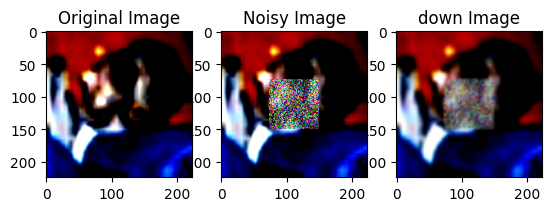

In [10]:
sample_img, label = test_dataset[0]

# Visualize the original and noisy image
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title('Original Image')


noisy_img = add_localized_noise(sample_img)

plt.subplot(1, 3, 2)
plt.imshow(np.transpose(noisy_img.numpy(), (1, 2, 0)))
plt.title('Noisy Image')

downsize_transform = transforms.Resize((80, 80))
down_img = downsize_transform(noisy_img)
upsize_transform = transforms.Resize((224, 224))
up_img = upsize_transform(down_img)

plt.subplot(1, 3, 3)
plt.imshow(np.transpose(up_img.numpy(), (1, 2, 0)))
plt.title('down Image')
plt.show()

In [11]:
# Creating folders
output_dir = '/content/noisy'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# import shutil
# shutil.rmtree('/content/noisy')

In [17]:
# labels_file = 'generated_dataset/labels.txt'
# downsize_transform = transforms.Resize((80, 80))

from google.colab.patches import cv2_imshow


for idx, (image_tensor, label) in enumerate(zip(noised_images, noised_labels)):
  # Convert the tensor to a PIL image
  img_array = image_tensor.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
  img_array = (img_array * 255).astype('uint8')  # Scale to [0, 255] for saving as PNG

  # cv2_imshow(img_array)

  img = Image.fromarray(img_array)

  # Construct filename and save
  img_filename = f"img_{idx + 1}.png"
  img_path = os.path.join(output_dir, img_filename)
  img.save(img_path)

print("written noisy dataset")

written noisy dataset


In [19]:
output_dir = '/content/noisy'
num_files = len(os.listdir(output_dir))
print(f"Number of files in '{output_dir}': {num_files}")

# Zip the '/content/shapes' directory
zip_filename = '/content/noisy.zip'
import zipfile
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, output_dir)  # Relative path to keep the structure
            zipf.write(file_path, arcname)

print(f"Zipped '{output_dir}' to '{zip_filename}'")

Number of files in '/content/noisy': 10000
Zipped '/content/noisy' to '/content/noisy.zip'


<ipython-input-101-a2298a956df0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(tensor_path)


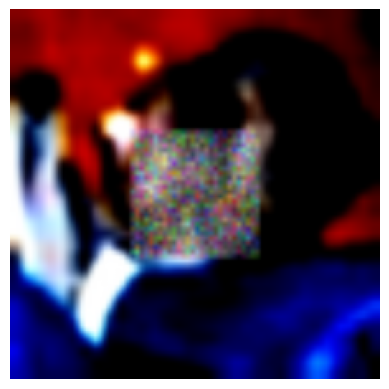

In [ ]:
tensor_path = '/content/generated_dataset/images/img_0000.pt'  # Adjust this to your desired image tensor
img_tensor = torch.load(tensor_path)
img_tensor = upsize_transform(img_tensor)
img  = load_image(img_tensor)
plt.imshow(img)
plt.axis('off')  # Remove axis lines and labels
plt.show()

In [47]:
file_path = '/content/noisy.zip'
file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB
print(f"File size: {file_size:.2f} MB")

File size: 485.64 MB


# **Scrambling images**

In [21]:
def scramble_image(image, patch_size=32):
    """Scramble the image by randomly permuting patches."""
    # Convert the image to a NumPy array and get dimensions
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Change to HWC format
    h, w, c = image_np.shape

    # Calculate the number of patches
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image_np[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch)

    # Randomly shuffle the patches
    np.random.shuffle(patches)

    # Reconstruct the image from scrambled patches
    scrambled_image = np.zeros_like(image_np)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            scrambled_image[i:i + patch_size, j:j + patch_size, :] = patches[idx]
            idx += 1

    return torch.tensor(scrambled_image).permute(2, 0, 1)  # Change back to CHW format


def apply_scrambling(data_loader):
    scrambled_images = []
    labels_list = []

    for images, labels in data_loader:
        for i,image in enumerate(images):
            scrambled_image = scramble_image(image)
            scrambled_images.append(scrambled_image.unsqueeze(0))  # Add batch dimension
            labels_list.append(labels[i].unsqueeze(0))             # Add batch dimension

    return torch.cat(scrambled_images), torch.cat(labels_list)

scrambled_images, scrambled_labels = apply_scrambling(test_loader)

In [22]:
print(len(scrambled_images), len(scrambled_labels),scrambled_images[0].shape)
print(scrambled_labels)

10000 10000 torch.Size([3, 224, 224])
tensor([3, 8, 8,  ..., 5, 1, 7])


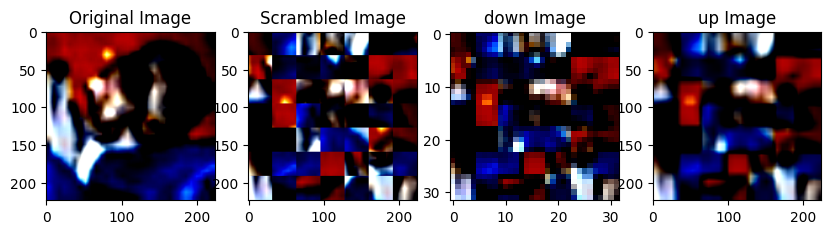

In [23]:
sample_img, label = test_dataset[0]

plt.figure(figsize=(10, 10))
# Visualize the original and noisy image
plt.subplot(1, 4, 1)
plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title('Original Image')

noisy_img = scramble_image(sample_img)

plt.subplot(1, 4, 2)
plt.imshow(np.transpose(noisy_img.numpy(), (1, 2, 0)))
plt.title('Scrambled Image')
# plt.show()

downsize_transform = transforms.Resize((32, 32))
upsize_transform = transforms.Resize((224, 224))

down_img = downsize_transform(noisy_img)

plt.subplot(1, 4, 3)
plt.imshow(np.transpose(down_img.numpy(), (1, 2, 0)))
plt.title('down Image')

up_img = upsize_transform(down_img)

plt.subplot(1, 4, 4)
plt.imshow(np.transpose(up_img.numpy(), (1, 2, 0)))
plt.title('up Image')
plt.show()

In [63]:
# Creating folders
output_dir = '/content/scrambled'
os.makedirs(output_dir, exist_ok=True)

In [64]:
# import shutil
# shutil.rmtree('/content/scrambled')

In [ ]:
# # Creating folders
# directory_name = 'generated_dataset/images'  # Change this to your desired folder name
# full_path = os.path.join('/content', directory_name)
# os.makedirs(full_path, exist_ok=True)
# file_path = '/content/generated_dataset/labels.txt'
# with open(file_path, 'w') as f:
#     pass
# print(f"Empty file created at: {file_path}")

Empty file created at: /content/generated_dataset/labels.txt


In [69]:
# labels_file = 'generated_dataset/labels.txt'
# downsize_transform = transforms.Resize((32, 32))


for idx, (image_tensor, label) in enumerate(zip(scrambled_images, scrambled_labels)):
  # print(image_tensor == img_tensor)
  # break

  # Convert the tensor to a PIL image
  img_array = np.transpose(image_tensor.cpu().numpy(), (1, 2, 0))
  # # Construct filename and save
  img_filename = f"img_{idx + 1}.png"
  img_path = os.path.join(output_dir, img_filename)
  np.save(img_path, img_array)

print("written scrambled dataset")

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [66]:
output_dir = '/content/scrambled'
num_files = len(os.listdir(output_dir))
print(f"Number of files in '{output_dir}': {num_files}")

# Zip the  directory
zip_filename = '/content/scrambled.zip'
import zipfile
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, output_dir)  # Relative path to keep the structure
            zipf.write(file_path, arcname)

print(f"Zipped '{output_dir}' to '{zip_filename}'")

Number of files in '/content/scrambled': 10000
Zipped '/content/scrambled' to '/content/scrambled.zip'


In [73]:
# file_path = '/content/scrambled.zip'
# file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB
# print(f"File size: {file_size:.2f} MB")

file_path = '/content/scrambled'
file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB
print(f"File size: {file_size:.2f} MB")

import os

folder_path = '/content/scrambled'

# List all files in the directory
files = os.listdir(folder_path)

# Loop through the first 10 files
for idx, file_name in enumerate(files[:10]):
    file_path = os.path.join(folder_path, file_name)

    # Ensure it's a file (not a directory)
    if os.path.isfile(file_path):
        # Get the size of the file in MB
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB
        print(f"File {idx + 1}: {file_name} - Size: {file_size:.2f} MB")


File size: 0.32 MB
File 1: img_5604.png.npy - Size: 0.57 MB
File 2: img_8743.png.npy - Size: 0.57 MB
File 3: img_2472.png.npy - Size: 0.57 MB
File 4: img_6999.png.npy - Size: 0.57 MB
File 5: img_1027.png.npy - Size: 0.57 MB
File 6: img_8723.png.npy - Size: 0.57 MB
File 7: img_1474.png.npy - Size: 0.57 MB
File 8: img_6708.png.npy - Size: 0.57 MB
File 9: img_8589.png.npy - Size: 0.57 MB
File 10: img_233.png.npy - Size: 0.57 MB


In [75]:
# from google.colab import drive
# import shutil

# # Mount Google Drive
# drive.mount('/content/drive')

# # # Copy folder to Google Drive
# # source_folder = '/content/scrambled'  # Replace with your folder name
# # destination_folder = '/content/drive/My Drive/ATML_Proj_Datasets/scrambled'  # Path in Google Drive
# # shutil.copytree(source_folder, destination_folder)

# # print(f"Folder copied to Google Drive: {destination_folder}")


# # Copy folder to Google Drive
# source_folder = '/content/noisy.zip'  # Replace with your folder name
# destination_folder = '/content/drive/My Drive/ATML_Proj_Datasets/noisy'  # Path in Google Drive
# shutil.copytree(source_folder, destination_folder)

# print(f"Folder copied to Google Drive: {destination_folder}")

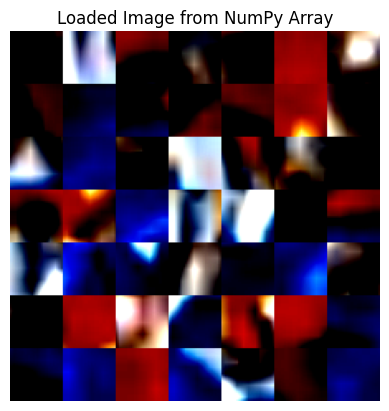

Tensor shape: torch.Size([3, 224, 224])


In [68]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Path to the .npy file
npy_file_path = '/content/scrambled/img_1.png.npy'

# Load the NumPy array
img_array = np.load(npy_file_path)

# Display the image using plt.imshow
plt.imshow(img_array)  # Assumes the array is in (H, W, C) format
plt.title("Loaded Image from NumPy Array")
plt.axis('off')
plt.show()

# Convert the NumPy array to a PyTorch tensor
img_tensor = torch.from_numpy(np.transpose(img_array, (2, 0, 1)))

# Print the shape of the tensor
print("Tensor shape:", img_tensor.shape)


<ipython-input-15-a2298a956df0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(tensor_path)


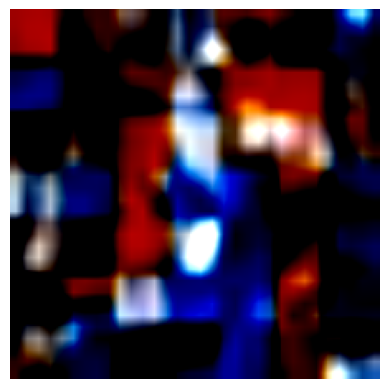

In [ ]:
tensor_path = '/content/generated_dataset/images/img_0000.pt'  # Adjust this to your desired image tensor
img_tensor = torch.load(tensor_path)
img_tensor = upsize_transform(img_tensor)
img  = load_image(img_tensor)
plt.imshow(img)
plt.axis('off')  # Remove axis lines and labels
plt.show()